# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import exoplanet as xo
import astropy.units as u
from astropy.timeseries import LombScargle
import lightkurve as lk
from astropy.io import fits

from uncertainties import ufloat
from uncertainties.umath import *
from scipy import constants

import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import pymc3_ext as pmx

import arviz as az

In [3]:
%matplotlib inline

In [4]:
mpl.rcParams["figure.figsize"] = (6, 4)
# mpl.rcParams["figure.dpi"] = 300
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['xtick.direction'] = 'inout'
mpl.rcParams['ytick.direction'] = 'inout'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

# System parameters

In [5]:
# from exofop: https://exofop.ipac.caltech.edu/tess/target.php?id=22233480
epoch_tess = ufloat(2459396.409578, 0.00075457105)
period_tess = ufloat(7.4463033768041, 0.000023020093)
depth_tess = ufloat(4045.7241784744, 128.28719)
duration_tess = ufloat(2.0033137761697, 0.15890975)
radius_tess = ufloat(2.4048644350425, 0.3086393)
insolation_tess = 5.6286113934149

stmass_tess = ufloat(0.363996, 0.0201927)
strad_tess = ufloat(0.375859, 0.0111301)

# RV reading

In [6]:
lbl_gl514 = pd.read_table('./data/lbl_toi4438_gl514/lbl_TOI4438_GL514.rdb', sep=None, engine='python', header=0)
lbl_gl699 = pd.read_table('./data/lbl_toi4438_gl699/lbl_TOI4438_GL699.rdb', sep=None, engine='python', header=0)
lbl2_gl699 = pd.read_table('./data/lbl_toi4438_gl699/lbl2_TOI4438_GL699_drift.rdb', sep=None, engine='python', header=0)
lbl_toi4438 = pd.read_table('./data/lbl_toi4438_toi4438/lbl_TOI4438_TOI4438.rdb', sep=None, engine='python', header=0)

lbl2_gl514_new = pd.read_table('./data/new_montreal/lbl2_TOI4438_GL514_bervzp.rdb', sep=None, engine='python', header=0)
lbl_gl514_new = pd.read_table('./data/new_montreal/lbl_TOI4438_GL514_bervzp.rdb', sep=None, engine='python', header=0)
lbl2_gl699_new = pd.read_table('./data/new_montreal/lbl2_TOI4438_GL699_bervzp.rdb', sep=None, engine='python', header=0)
lbl2_gl699_new2 = lbl2_gl699_new[['rjd', 'vrad', 'svrad']]

lbl2_gl699_car = pd.read_table('./data/lbl2_carmona/lbl2_TOI4438_GL699.rdb', sep=None, engine='python', header=0)
lbl2_gl905_car = pd.read_table('./data/lbl2_carmona/lbl2_TOI4438_GL905.rdb', sep=None, engine='python', header=0)
lbl2_toi4438_car = pd.read_table('./data/lbl2_carmona/lbl2_TOI4438_TOI4438.rdb', sep=None, engine='python', header=0)

carmenes = pd.read_table('./data/carmenes_data/carmenes.rdb', sep=None, engine='python', header=0)
# substract 2400000 to the BJD time
carmenes['rjd'] = carmenes['rjd'] - 2400000
# names = ['lbl_gl514', 'lbl_gl699', 'lbl_toi4438']
names = ['carmenes', 'lbl2_gl699_new']

star_name = 'toi4438'

In [7]:
carmenes.columns

Index(['rjd', 'vrad', 'svrad'], dtype='object')

In [8]:
print(len(lbl_gl514), len(lbl_gl699), len(lbl_toi4438), len(lbl2_gl699_car), len(lbl2_gl905_car), len(lbl2_toi4438_car))
print(len(lbl_gl514_new), len(lbl2_gl514_new), len(lbl2_gl699))

197 197 197 51 51 51
199 51 51


In [9]:
#datasets = list([lbl_gl514, lbl_gl699, lbl_toi4438])
datasets = list([carmenes, lbl2_gl699_new2])

In [12]:
for i, data in enumerate(datasets):
    print(np.median(data['vrad']))

-0.245
-35086.433042304714


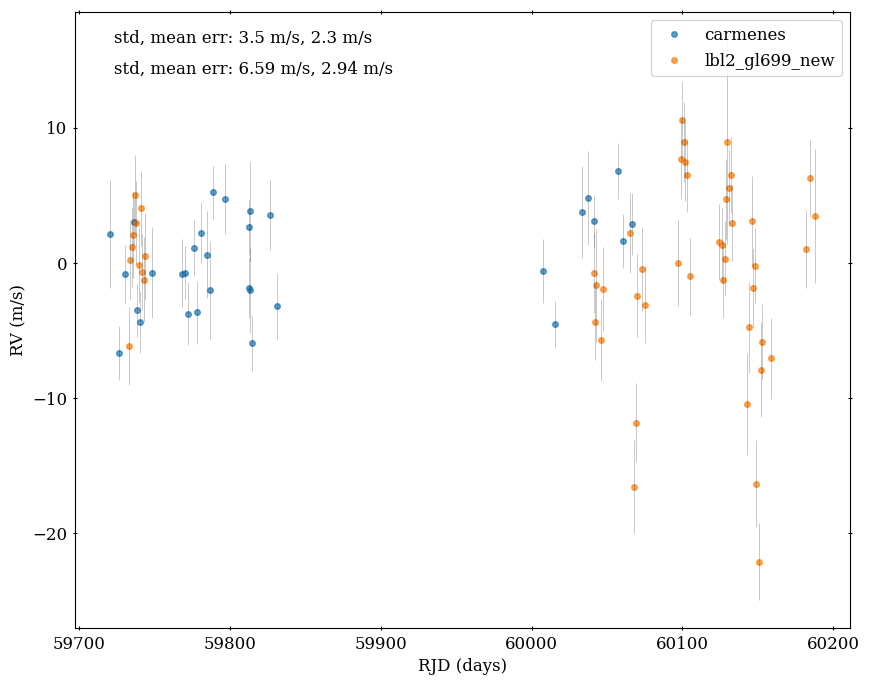

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i, data in enumerate(datasets):
    ax.plot(data['rjd'], data['vrad']-np.median(data['vrad']), 'o', ms=4, label=names[i], alpha=0.7)
    ax.errorbar(data['rjd'], data['vrad']-np.median(data['vrad']), yerr=data['svrad'], fmt='o', color='k', ms=0, alpha=0.3, elinewidth=0.5)
    ax.set_ylabel('RV (m/s)')
    ax.set_xlabel('RJD (days)')
    ax.text(0.05, 0.95-i*0.05, 'std, mean err: '+str(round(np.std(data['vrad']), 2))+' m/s, '+str(round(np.median(data['svrad']),2))+' m/s', transform=ax.transAxes)
ax.legend(loc='upper right')
plt.savefig('rvs_'+star_name+'.png', dpi=300, facecolor='w')
plt.show()

## outliers?

In [14]:
for i in range(len(datasets)):
    print(datasets[i].shape)

(32, 3)
(51, 3)


In [15]:
outliers = []
for k, data in enumerate(datasets):
    sigmas = 3
    datasets[k] = data[np.abs(data['vrad'] - data['vrad'].mean()) <= (sigmas * data['vrad'].std())].reset_index(drop=True)
    a = np.abs(data['vrad'] - data['vrad'].mean()) <= (3 * data['vrad'].std())
    outliers.append(np.size(a) - np.count_nonzero(a))
print(outliers)

[0, 1]


In [16]:
# substract the systemic velocity 
for i in datasets:
    i['vrad'] = i['vrad'].apply(lambda x: x - i['vrad'].median())

In [17]:
# print the 5 points with largest errorbar
for k, data in enumerate(datasets):
    print(data['svrad'].sort_values(ascending=False).head(5))

0     3.99
19    3.72
14    3.63
27    3.48
26    3.38
Name: svrad, dtype: float64
34    7.542942
49    4.948958
13    4.189355
38    3.758465
44    3.489217
Name: svrad, dtype: float64


In [18]:
# print the 5 points with largest errorbar
# for k, data in enumerate(datasets):
#     print(data['EXTSN035'].sort_values(ascending=True).head(5))

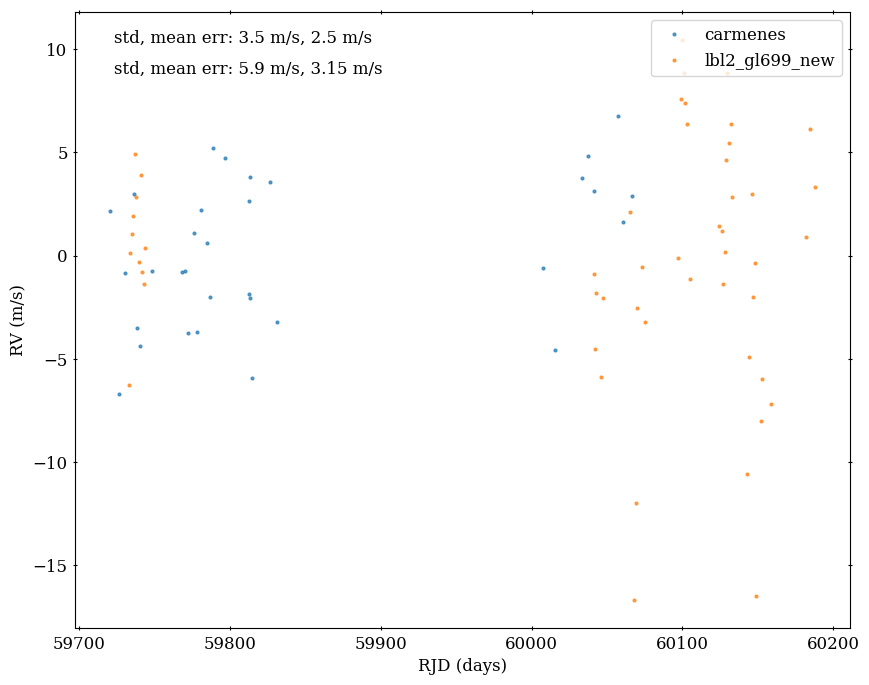

In [19]:
# replot without outliers
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i, data in enumerate(datasets):
    ax.plot(data['rjd'], data['vrad']-np.median(data['vrad']), 'o', ms=2, label=names[i], alpha=0.7)
    ax.set_ylabel('RV (m/s)')
    ax.set_xlabel('RJD (days)')
    ax.text(0.05, 0.95-i*0.05, 'std, mean err: '+str(round(np.std(data['vrad']), 2))+' m/s, '+str(round(np.mean(data['svrad']),2))+' m/s', transform=ax.transAxes)
ax.legend(loc='upper right')
plt.show()

# GLS

In [20]:
ls = dict()
frequency = dict()
power = dict()
faps = dict()

for k, data in enumerate(datasets):
    ls[k] = LombScargle(data['rjd'], data['vrad'], data['svrad'])
    frequency[k], power[k] = ls[k].autopower(minimum_frequency=0.01, maximum_frequency=2, samples_per_peak=15)
    probabilities = [0.05]
    faps[k] = ls[k].false_alarm_level(probabilities)

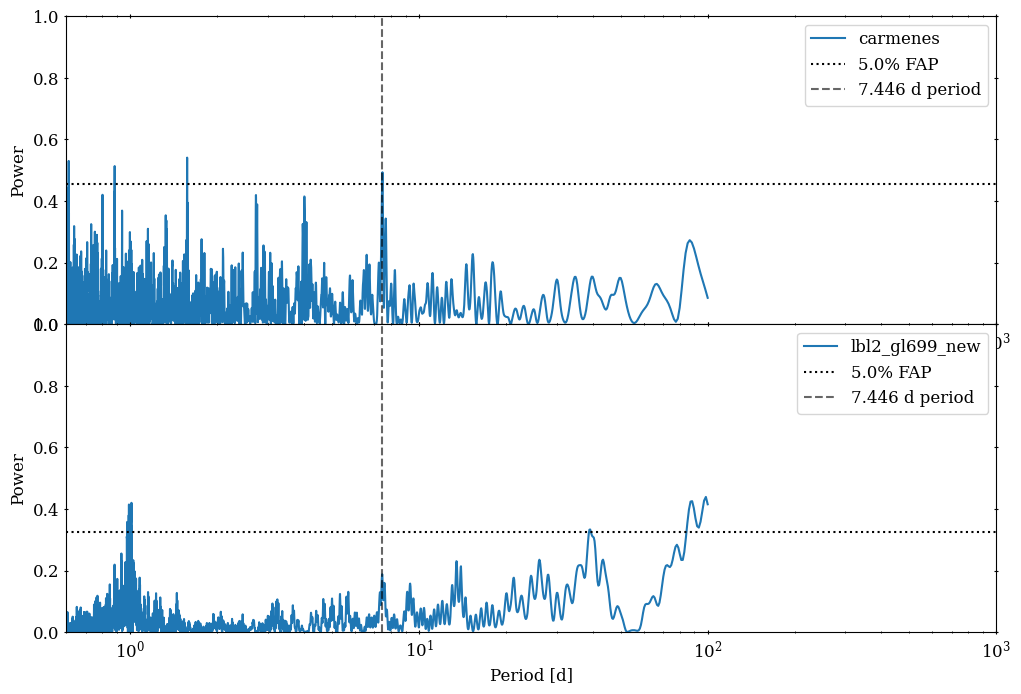

In [21]:
fig, axes = plt.subplots(len(datasets),1, sharex=False, figsize=(12, 4*len(datasets)))
fig.subplots_adjust(hspace=0.0, wspace=0.0)

for i in range(len(datasets)):
    axes[i].plot(1/frequency[i], power[i], label=names[i])
    axes[i].axhline(faps[i], ls=':', color='black', label='{}% FAP'.format(probabilities[0]*100))
    axes[i].set_xscale('log')
    axes[i].set_xlim(0.6, 1000)
    axes[i].set_ylim(0, 1.0)
    axes[i].set_ylabel('Power')
    axes[i].set_xlabel('Period [d]')
    axes[i].axvline(period_tess.n, ls='--', color='black', alpha=0.6, label='{} d period'.format(round(period_tess.n, 3)))
    axes[i].legend(loc='upper right')
    axes[i].set_ylim(0, 1)

# RV fit 

In [22]:
x_ref = dict()
maxrv = dict()

for k, data in enumerate(datasets):
    x_ref[k] = 0.5 * (data['rjd'].min() + data['rjd'].max())
    maxrv[k] = np.std(data['vrad'])*3

In [33]:
from collections import OrderedDict

datasets2 = OrderedDict(
    [
        ("carmenes", [datasets[0].rjd, datasets[0].vrad, datasets[0].svrad]),
        ("spirou", [datasets[1].rjd, datasets[1].vrad, datasets[1].svrad]),
    ]
)

In [38]:
# Make a fine grid that spans the observation window for plotting purposes
model = dict()
t = dict()

with pm.Model() as model:
    logP = pm.Normal("logP", mu=np.log(period_tess.n), sd=period_tess.s/period_tess.n) #period_tess.s/period_tess.n
    P = pm.Deterministic("P", tt.exp(logP))

    K = pm.Uniform("K", lower=0, upper=maxrv[k])

    trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)  # [2,1,0]

    BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1)
    mstar = BoundedNormal("mstar", mu=stmass_tess.n, sd=stmass_tess.s)
    rstar = BoundedNormal("rstar", mu=strad_tess.n, sd=strad_tess.s)

    t0 = pm.Normal("t0", mu=epoch_tess.n-2400000, sd=epoch_tess.s)

    orbit = xo.orbits.KeplerianOrbit(period=P, 
                                    t0=t0, 
                                    r_star=rstar, 
                                    m_star=mstar)

    # derive mass and semi-major axis
    m_pl = pm.Deterministic('m_pl', K*(P*u.day.to(u.second)*(mstar*u.M_sun.to(u.kg))**2/(2*np.pi*constants.G))**(1/3))
    a = pm.Deterministic('a', ((P*u.day.to(u.second))**2*constants.G*(mstar*u.M_sun.to(u.kg)+m_pl)/(4*np.pi**2))**(1/3)*u.m.to(u.au))

    # And a function for computing the full RV model
    def get_rv_model(t, name=""):
        # First the RVs induced by the planet
        vrad = orbit.get_radial_velocity(t, K=K)
        pm.Deterministic("vrad" + name, vrad)

        # Define the background model
        A = np.vander(t - x_ref[k], 3) # Generate a Vandermonde matrix with t-x_ref as input vector
        bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

        # Sum planet and background to get the full model
        return pm.Deterministic("rv_model" + name, vrad + bkg)
        
    # loop over the instruments
    rv_models = dict()
    rv_obs = dict()
    rv_model_preds = dict()

    for n, (name, (rjd, vrad, svrad)) in enumerate(datasets2.items()):
        t[n] = np.linspace(rjd.min() - 5, rjd.max() + 5, 3000)
        
        with pm.Model(name=name, model=model):
            rv_models[name] = get_rv_model(rjd)
            rv_model_preds[name] = get_rv_model(t[n], name="_pred")
            logs = pm.Normal("logs", mu=np.log(np.median(np.asarray(svrad))), sd=5.0)
            trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)  # [2,1,0]

        # Finally add in the observation model
        err = tt.sqrt(np.asarray(svrad)**2  + tt.exp(2 * logs))
        rv_obs = pm.Normal(f"{name}_obs", mu=rv_models[name], sd=err, observed=np.asarray(vrad))

In [39]:
with model:
    map_soln = pmx.optimize(start=model.test_point)
    #map_soln = pmx.optimize(start=map_soln, vars=[logP, K, logs, t0])
    map_soln = pmx.optimize(start=map_soln)

optimizing logp for variables: [spirou_trend, spirou_logs, carmenes_trend, carmenes_logs, t0, rstar, mstar, trend, logs, K, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -342.3356900611426 -> -203.74332158792
optimizing logp for variables: [spirou_trend, spirou_logs, carmenes_trend, carmenes_logs, t0, rstar, mstar, trend, logs, K, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -203.74332158792 -> -203.74332158792


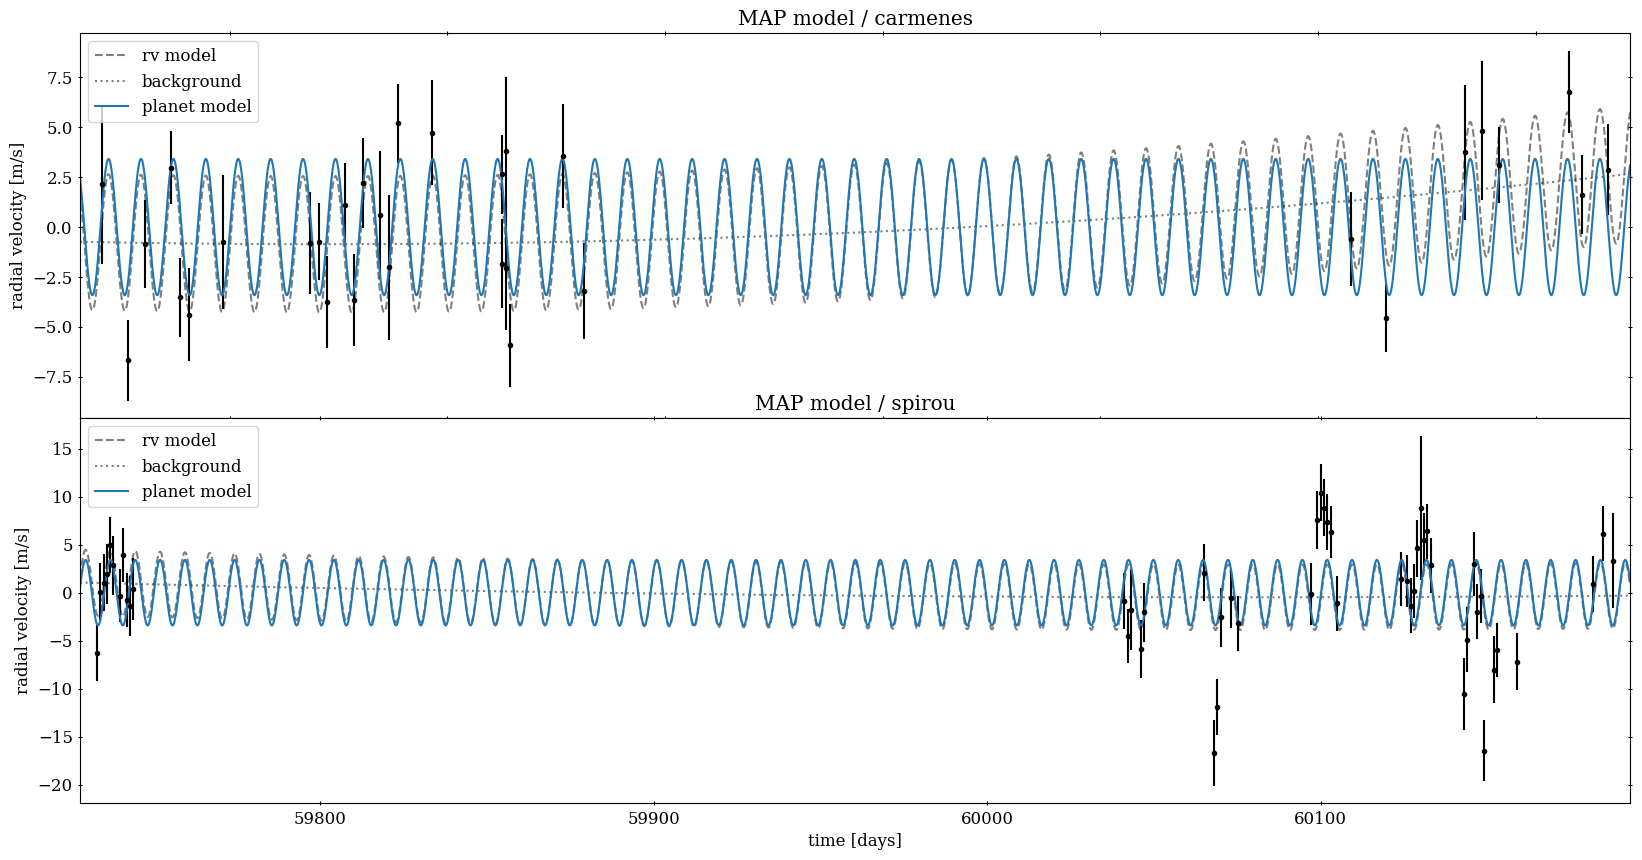

In [55]:
fig, ax = plt.subplots(2, 1, figsize=(20, 5*2))
fig.subplots_adjust(hspace=0.0, wspace=0.0)

for k, name in enumerate(datasets2):
    x, y, yerr = datasets2[name][:3]
    ax[k].errorbar(x, y, yerr=yerr, fmt=".k")
    ax[k].plot(t[k], map_soln[f"{name}_rv_model_pred"], "--k", alpha=0.5, label='rv model')
    ax[k].plot(t[k], map_soln[f"{name}_bkg_pred"], ":k", alpha=0.5, label="background")
    ax[k].plot(t[k], map_soln[f"{name}_vrad_pred"], label="planet model")

    ax[k].legend(loc="upper left")
    ax[k].set_xlim(t[k].min(), t[k].max())
    ax[k].set_xlabel("time [days]")
    ax[k].set_ylabel("radial velocity [m/s]")
    _ = ax[k].set_title("MAP model"+' / '+name)

# Sampling

In [56]:

with model:
    traces = pmx.sample(
        tune=2000,
        draws=2000,
        cores=2,
        chains=2,
        target_accept=0.95,
        return_inferencedata=True,)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [spirou_trend, spirou_logs, carmenes_trend, carmenes_logs, t0, rstar, mstar, trend, logs, K, logP]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


In [59]:
traces

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [60]:

summary= az.summary(traces, stat_funcs={'median': np.median, 'std':np.std}, hdi_prob=0.997, round_to=6,
                var_names=[
                    't0', 'logP', 'P', 'K', 'mstar', 'rstar', 'm_pl', 'a'
                    ])
print(summary.ess_bulk.mean(), summary.ess_tail.mean(), summary.r_hat.max())


3457.9181930000004 2620.9549850000003 1.000353


In [61]:
summary

,mean,sd,hdi_0.15%,hdi_99.85%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,std
t0,5.939641e+04,7.720000e-04,5.939641e+04,5.939641e+04,1.400000e-05,1.000000e-05,3028.558756,2493.640717,1.000208,5.939641e+04,7.720000e-04
logP,2.007718e+00,3.000000e-06,2.007709e+00,2.007727e+00,0.000000e+00,0.000000e+00,3533.280272,2874.008288,1.000050,2.007718e+00,3.000000e-06
P,7.446303e+00,2.300000e-05,7.446239e+00,7.446375e+00,0.000000e+00,0.000000e+00,3533.280272,2874.008288,1.000050,7.446304e+00,2.300000e-05
K,3.387173e+00,4.961400e-01,2.029353e+00,4.898790e+00,8.748000e-03,6.186000e-03,3231.432579,2137.350684,1.000257,3.389722e+00,4.960780e-01
mstar,3.641620e-01,1.995000e-02,3.037630e-01,4.238370e-01,3.230000e-04,2.280000e-04,3831.937518,3037.557929,0.999881,3.644460e-01,1.994700e-02
rstar,3.756400e-01,1.107300e-02,3.432100e-01,4.073020e-01,1.930000e-04,1.370000e-04,3289.817833,2311.785826,1.000353,3.757470e-01,1.107200e-02
m_pl,3.149211e+25,4.760619e+24,1.824888e+25,4.611047e+25,8.171746e+22,5.778794e+22,3382.767157,2201.730219,1.000321,3.145562e+25,4.760024e+24
a,5.327500e-02,9.760000e-04,5.016600e-02,5.605700e-02,1.600000e-05,1.100000e-05,3832.271157,3037.557929,0.999873,5.330600e-02,9.760000e-04


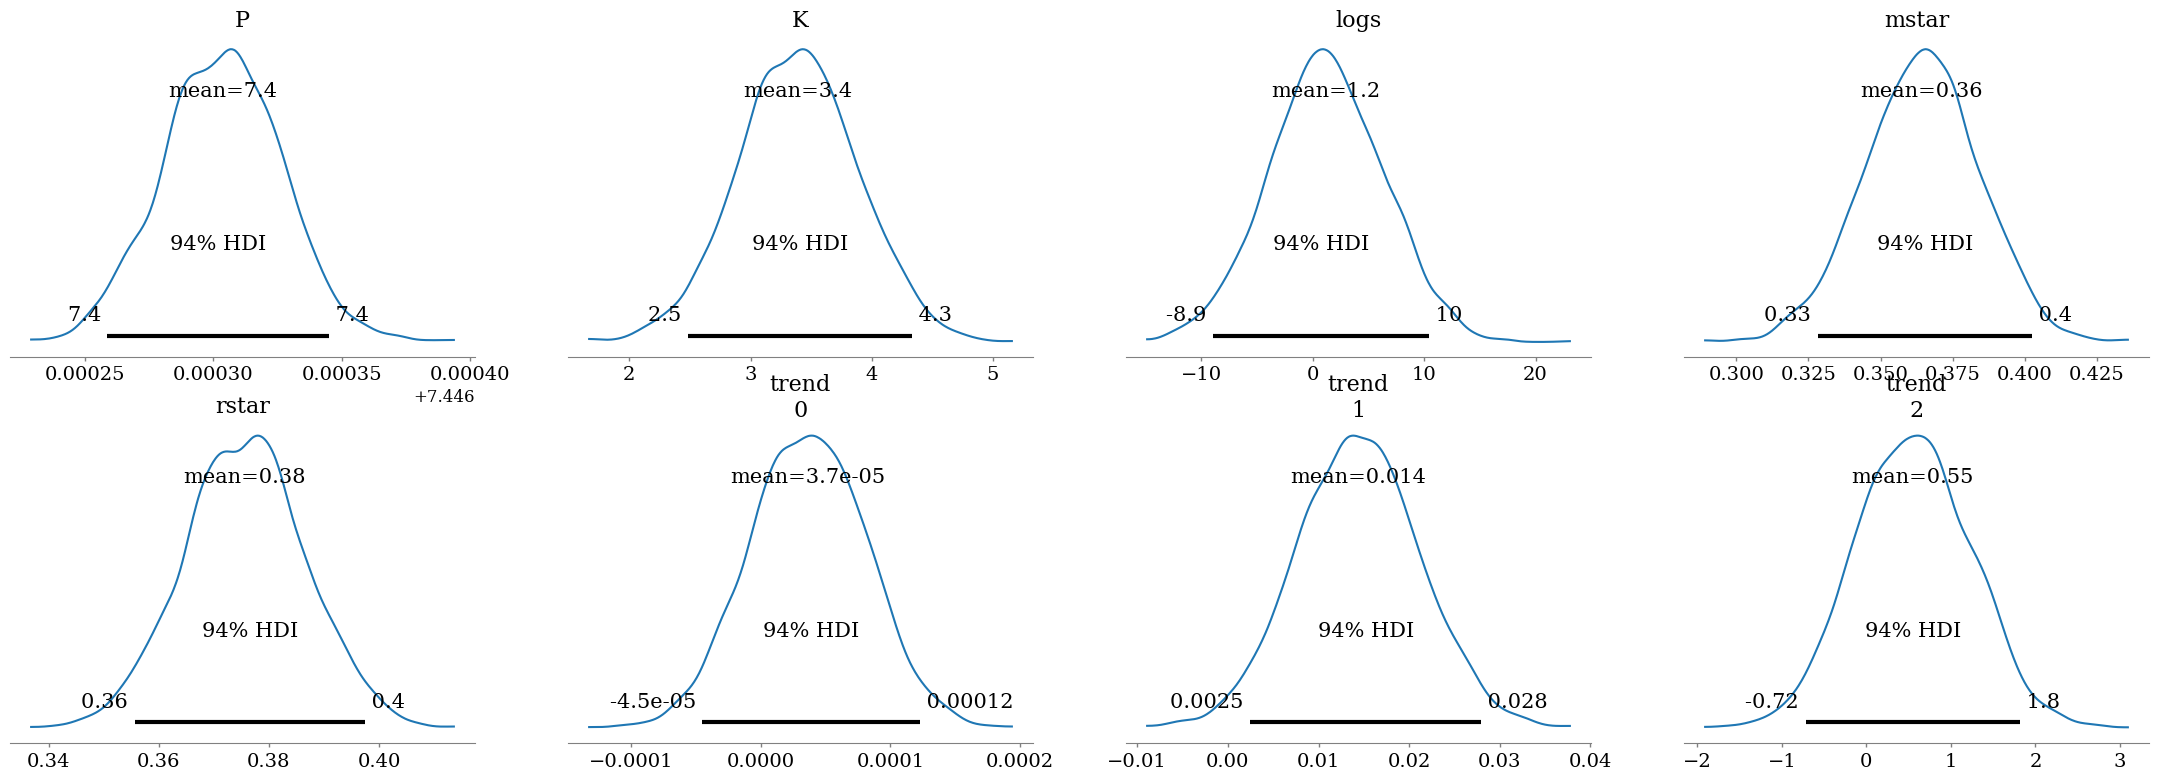

In [62]:
az.plot_posterior(traces, var_names=['P', 'K', 'mstar', 'rstar', 'trend'])
plt.show()

## Results

In [67]:
mass = dict()
K = dict()
period = dict()
t_0 = dict()
m_star = dict()
r_star = dict()
smaxis = dict()
rv_jitter_ = dict()
bkg_ = dict()
rv_model = dict()
rv_model_pred = dict()
rv_model_pred_ = dict()
flat_samps = dict()

mass = ufloat((traces.posterior["m_pl"].median().item()*u.kg).to(u.M_earth).value, (traces.posterior["m_pl"].std().item()*u.kg).to(u.M_earth).value)
K = ufloat(traces.posterior["K"].median().item(), traces.posterior["K"].std().item())
period = ufloat(traces.posterior['P'].median().item(),traces.posterior['P'].std().item())
t_0 = ufloat(traces.posterior['t0'].median().item(), traces.posterior['t0'].std().item())
m_star = ufloat(traces.posterior['mstar'].median().item(), traces.posterior['mstar'].std().item())
r_star = ufloat(traces.posterior['rstar'].median().item(), traces.posterior['rstar'].std().item())
smaxis = ufloat(traces.posterior['a'].median().item(), traces.posterior['a'].std().item())
carmenes_logsigma_rv = ufloat(traces.posterior["carmenes_logs"].median().item(), traces.posterior["carmenes_logs"].std().item())
spirou_logsigma_rv = ufloat(traces.posterior["spirou_logs"].median().item(), traces.posterior["spirou_logs"].std().item())
carmenes_rv_jitter_ = np.e**carmenes_logsigma_rv
spirou_rv_jitter_ = np.e**spirou_logsigma_rv
flat_samps = traces.posterior.stack(sample=("chain", "draw"))
spirou_bkg_ = np.median(flat_samps['spirou_bkg'].values, axis=-1)
carmenes_bkg_ = np.median(flat_samps['carmenes_bkg'].values, axis=-1)
spirou_rv_model = np.median(flat_samps['spirou_rv_model'].values, axis=-1)
carmenes_rv_model = np.median(flat_samps['carmenes_rv_model'].values, axis=-1)
spirou_rv_model_pred = np.median(flat_samps['spirou_rv_model_pred'].values, axis=-1)
carmenes_rv_model_pred = np.median(flat_samps['carmenes_rv_model_pred'].values, axis=-1)
spirou_rv_model_pred_ = np.percentile(traces.posterior["spirou_rv_model_pred"].values,[16, 50, 84], axis=(0, 1))
carmenes_rv_model_pred_ = np.percentile(traces.posterior["carmenes_rv_model_pred"].values,[16, 50, 84], axis=(0, 1))

print("Mp = {m:.3f} Mearth".format(m=mass))
print('K = {k:.3f} m/s'.format(k=K))
print("P = {p:.6f} days".format(p=period))
print("Epoch = {e:.5f}".format(e=t_0))
print('a = {a:.4f} AU'.format(a=smaxis))
print('mstar = {m:.3f} Msun'.format(m=m_star))
print('rstar = {r:.3f} Rsun'.format(r=r_star))
print("spirou RV jitter = ", spirou_rv_jitter_)
print("carmenes RV jitter = ", carmenes_rv_jitter_)


Mp = 5.267+/-0.797 Mearth
K = 3.390+/-0.496 m/s
P = 7.446304+/-0.000023 days
Epoch = 59396.40959+/-0.00077
a = 0.0533+/-0.0010 AU
mstar = 0.364+/-0.020 Msun
rstar = 0.376+/-0.011 Rsun
spirou RV jitter =  4.3+/-0.7
carmenes RV jitter =  0.1+/-0.4


In [31]:
# REDUCTION:  carmenes
# Mp = 5.238+/-0.936 Mearth
# K = 3.371+/-0.591 m/s
# P = 7.446303+/-0.000023 days
# Epoch = 59396.40956+/-0.00075
# a = 0.0533+/-0.0010 AU
# mstar = 0.364+/-0.020 Msun
# rstar = 0.376+/-0.011 Rsun
# RV jitter =  0.2+/-0.5
# ---------------------------------------------
# REDUCTION:  lbl2_gl699_new
# Mp = 4.930+/-1.734 Mearth
# K = 3.187+/-1.106 m/s
# P = 7.446303+/-0.000023 days
# Epoch = 59396.40956+/-0.00075
# a = 0.0533+/-0.0010 AU
# mstar = 0.364+/-0.020 Msun
# rstar = 0.376+/-0.011 Rsun
# RV jitter =  5.0+/-0.7
# ---------------------------------------------

## Plot results

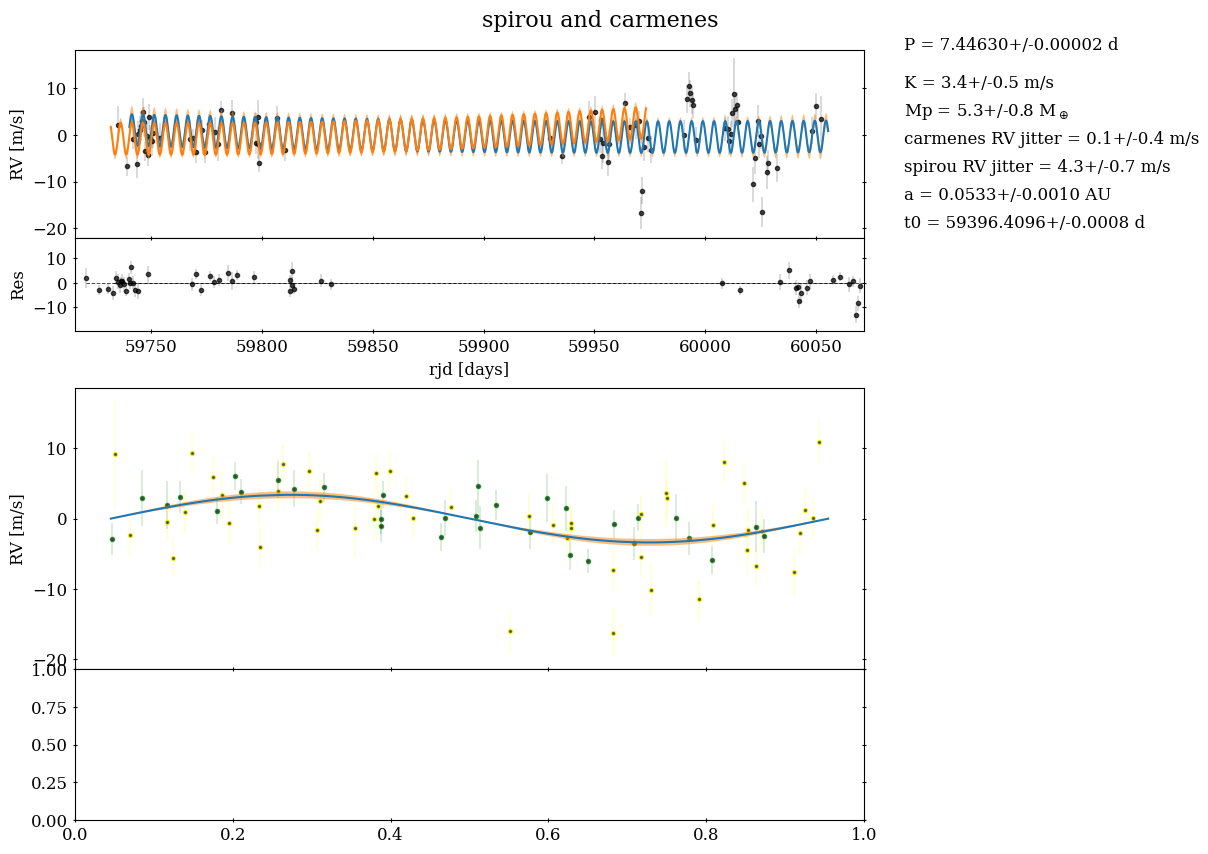

In [89]:
# make a grid of 3 subplots in a column
gs_kw = dict(width_ratios=[4,1], height_ratios=[1, 0.5, 0.3, 1.5, 0.8], hspace=0.0)

fig, ax = plt.subplots(5, 2, figsize=(14, 10), gridspec_kw=gs_kw)
fig.suptitle('spirou and carmenes', y=0.92, fontsize=16)
# delete the three empty subplots and add the parameters in text
for i in range(5):
    ax[i,1].xaxis.set_visible(False)
    ax[i,1].yaxis.set_visible(False)
    ax[i,1].spines['left'].set_visible(False)
    ax[i,1].spines['right'].set_visible(False)
    ax[i,1].spines['top'].set_visible(False)
    ax[i,1].spines['bottom'].set_visible(False)
    if i==0 or i==3:
        ax[i,0].set_xticks([])
        ax[i,0].set_xticklabels([])

ax[0,1].text(-0.3, 1., 'P = {p:.5f} d'.format(p=period), fontsize=12)
ax[0,1].text(-0.3, 0.8, 'K = {k:.1f} m/s'.format(k=K), fontsize=12)
ax[0,1].text(-0.3, 0.65, 'Mp = {m:.1f} M$_\oplus$'.format(m=mass), fontsize=12)
ax[0,1].text(-0.3, 0.5, 'carmenes RV jitter = {j:.1f} m/s'.format(j=carmenes_rv_jitter_), fontsize=12)
ax[0,1].text(-0.3, 0.35, 'spirou RV jitter = {j:.1f} m/s'.format(j=spirou_rv_jitter_), fontsize=12)
ax[0,1].text(-0.3, 0.2, 'a = {a:.4f} AU'.format(a=smaxis), fontsize=12)
ax[0,1].text(-0.3, 0.05, 't0 = {t:.4f} d'.format(t=t_0), fontsize=12)
    
# plot the RVs and the model in the first subplot
ax[0,0].errorbar(datasets2['carmenes'][0], datasets2['carmenes'][1], yerr=datasets2['carmenes'][2], fmt=".k", 
                 label='rvs', markeredgecolor='k', ecolor='k', elinewidth=0.3, alpha=0.7, zorder=-10)
ax[0,0].errorbar(datasets2['spirou'][0], datasets2['spirou'][1], yerr=datasets2['spirou'][2], fmt=".k", 
                 label='rvs', markeredgecolor='k', ecolor='k', elinewidth=0.3, alpha=0.7, zorder=-10)
ax[0,0].plot(t[1], spirou_rv_model_pred_[1], label='spirou model')
ax[0,0].plot(t[0], carmenes_rv_model_pred_[1], label='carmenes model')
art = ax[0,0].fill_between(t[1], spirou_rv_model_pred_[0], spirou_rv_model_pred_[2], color="#FF7F00", alpha=0.5) 
art2 = ax[0,0].fill_between(t[0], carmenes_rv_model_pred_[0], carmenes_rv_model_pred_[2], color="#FF7F00", alpha=0.5) 
art.set_edgecolor("none")
art2.set_edgecolor("none")
ax[0,0].set_ylabel("RV [m/s]")

# add the residuals in the second subplot
ax[1,0].hlines(0, datasets2['carmenes'][0].min(), datasets2['carmenes'][0].max(), ls='--', lw=0.7, alpha=0.7, color='k')
ax[1,0].errorbar(datasets2['carmenes'][0], datasets2['carmenes'][1]-carmenes_rv_model, yerr=datasets2['carmenes'][2], fmt=".k", 
                label='residuals', markeredgecolor='k', ecolor='k', elinewidth=0.3, alpha=0.7, zorder=-10)
ax[1,0].hlines(0, datasets2['spirou'][0].min(), datasets2['spirou'][0].max(), ls='--', lw=0.7, alpha=0.7, color='k')
ax[1,0].errorbar(datasets2['spirou'][0], datasets2['spirou'][1]-spirou_rv_model, yerr=datasets2['spirou'][2], fmt=".k", 
                label='residuals', markeredgecolor='k', ecolor='k', elinewidth=0.3, alpha=0.7, zorder=-10)
ax[1,0].set_xlim(datasets2['carmenes'][0].min()-5, datasets2['carmenes'][0].max()+5)
ax[1,0].set_xlabel("rjd [days]")
ax[1,0].set_ylabel("Res")
# plot the folded data
x_fold_carmenes = (datasets2['carmenes'][0] - t_0.n + 0.5 * period.n) % period.n - 0.5 * period.n
x_fold_spirou = (datasets2['spirou'][0] - t_0.n + 0.5 * period.n) % period.n - 0.5 * period.n
ax[3,0].errorbar(x_fold_carmenes/period.n, datasets2['carmenes'][1]-carmenes_bkg_, yerr=datasets2['carmenes'][2], fmt=".k",
            markeredgecolor='green', ecolor='green', elinewidth=0.3, label='', alpha=0.7, zorder=-10) 
ax[3,0].errorbar(x_fold_spirou/period.n, datasets2['spirou'][1]-spirou_bkg_, yerr=datasets2['spirou'][2], fmt=".k",
            markeredgecolor='yellow', ecolor='yellow', elinewidth=0.3, label='', alpha=0.7, zorder=-10) 
# # delete the third subplot so it shows as a gap
ax[2,0].set_visible(False)

# compute the posterior prediction for the folded RV model
t_fold = (t[0] - t_0.n + 0.5 * period.n) % period.n - 0.5 * period.n
inds = np.argsort(t_fold)
pred_rvs = np.percentile(traces.posterior["carmenes_vrad_pred"].values,[16, 50, 84], axis=(0, 1))
ax[3,0].plot(t_fold[inds]/period.n, pred_rvs[1][inds], label='folded carmenes model')
art = ax[3,0].fill_between(t_fold[inds]/period.n, pred_rvs[0][inds], pred_rvs[2][inds], color="#FF7F00", alpha=0.5) 
art.set_edgecolor("none")
ax[3,0].set_ylabel("RV [m/s]")

# # plot the residuals
# ax[4,0].hlines(0, -0.5, 0.5, ls='--', lw=0.7, alpha=0.7, color='k')
# ax[4,0].errorbar(x_fold/period[k].n, data['vrad']-rv_model[k], yerr=data['svrad'], fmt=".k", 
#                 label='residuals', markeredgecolor='k', ecolor='k', elinewidth=0.3, alpha=0.7, zorder=-10)
# ax[4,0].set_xticks([-0.5, -0.25, 0, 0.25, 0.5])
# ax[4,0].set_ylabel("Res")
# ax[4,0].set_xlabel("Phase")
# # show the std of the residuals
# ax[4,0].text(0.05, 0.90, 'std: '+str(round(np.std(data['vrad']-rv_model[k]), 2))+' m/s', transform=ax[4,0].transAxes)
# ax[4,0].set_xlim(-0.51, 0.51)
# ax[4,0].set_xticks([-0.40, -0.20, 0, 0.40, 0.20])
# ax[3,0].sharex(ax[4,0])

# savefig with name
#plt.savefig('fit_'+names[k]+'.png', dpi=300, facecolor='w', bbox_inches='tight')
plt.show()

In [79]:
datasets2['carmenes'][1]

0     2.145
1    -6.685
2    -0.865
3     2.985
4    -3.525
5    -4.395
6    -0.735
7    -0.805
8    -0.725
9    -3.765
10    1.105
11   -3.675
12    2.215
13    0.605
14   -2.015
15    5.215
16    4.735
17   -1.835
18    2.645
19    3.815
20   -2.045
21   -5.925
22    3.565
23   -3.195
24   -0.605
25   -4.555
26    3.755
27    4.825
28    3.105
29    6.775
30    1.625
31    2.885
Name: vrad, dtype: float64

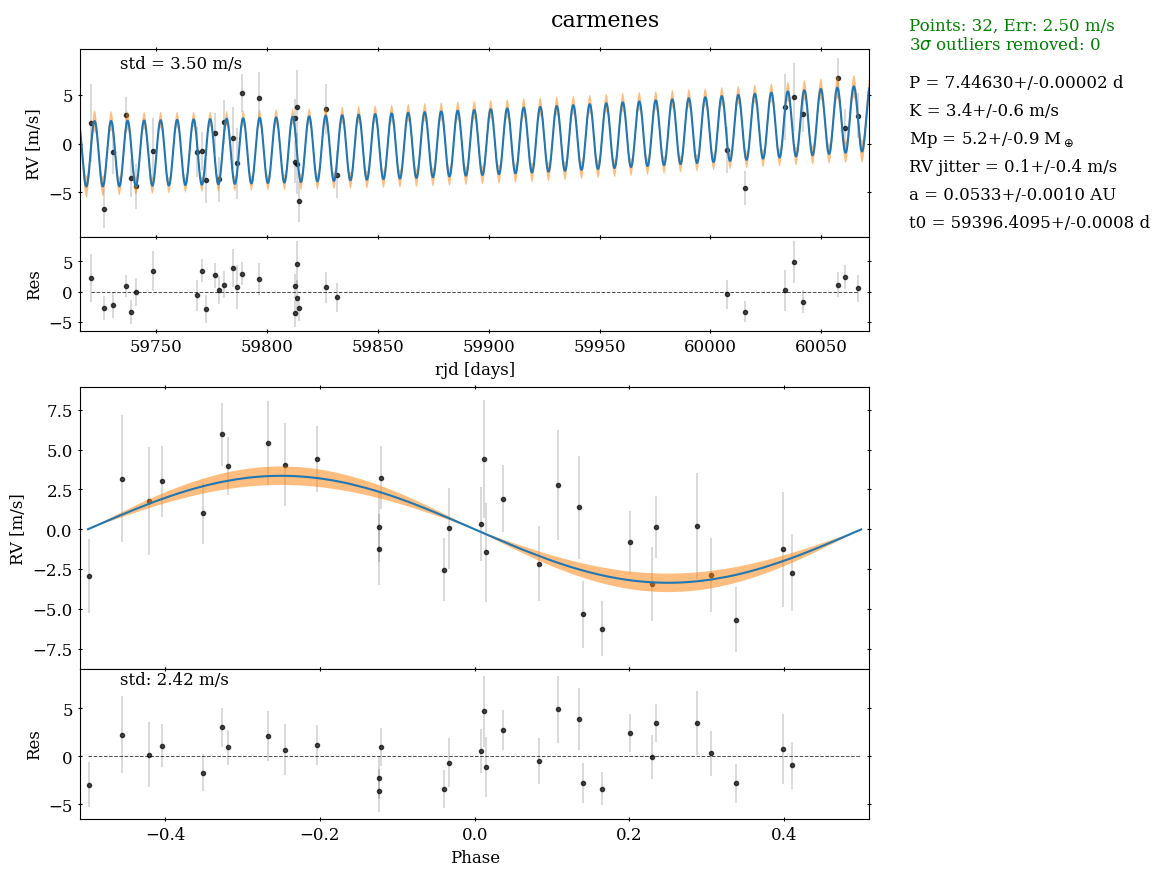

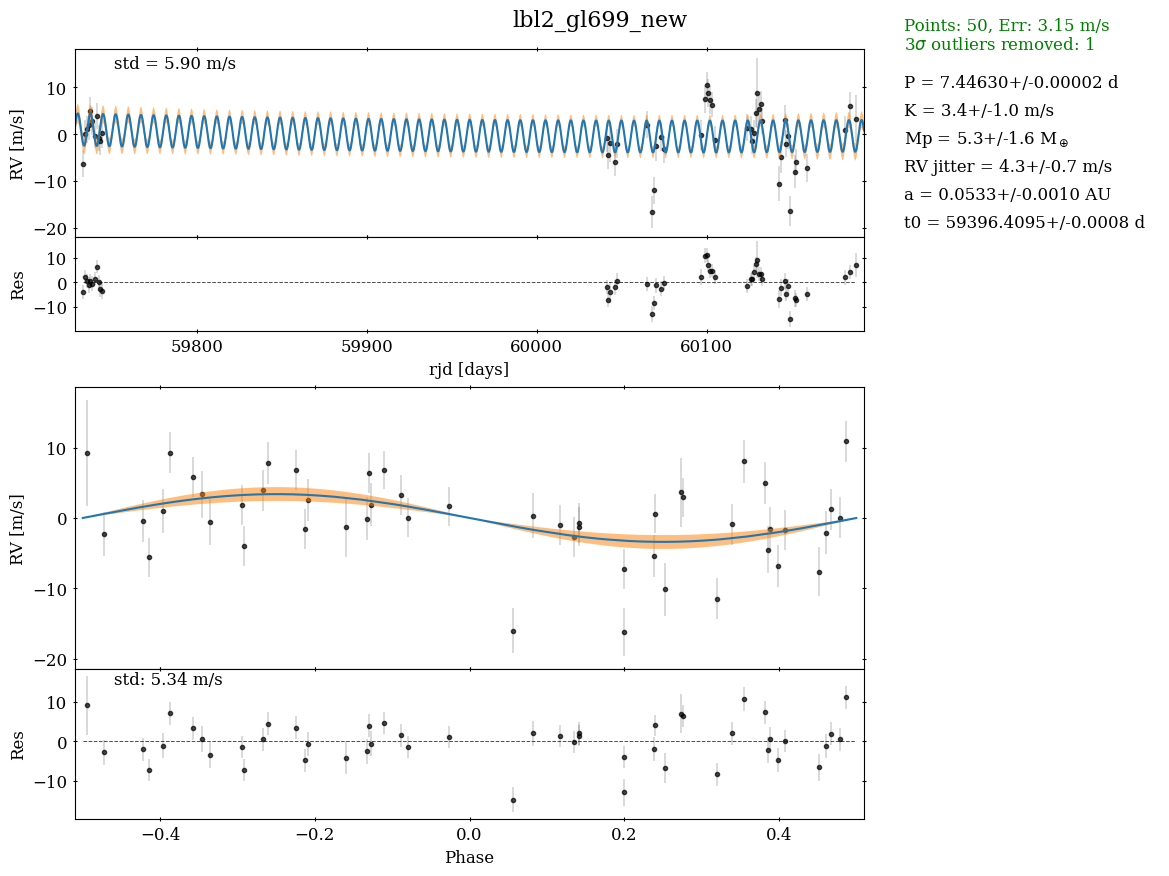

In [32]:
# make a grid of 3 subplots in a column
gs_kw = dict(width_ratios=[4,1], height_ratios=[1, 0.5, 0.3, 1.5, 0.8], hspace=0.0)

for k, data in enumerate(datasets):
    fig, ax = plt.subplots(5, 2, figsize=(14, 10), gridspec_kw=gs_kw)
    fig.suptitle(names[k], y=0.92, fontsize=16)
    # delete the three empty subplots and add the parameters in text
    for i in range(5):
        ax[i,1].xaxis.set_visible(False)
        ax[i,1].yaxis.set_visible(False)
        ax[i,1].spines['left'].set_visible(False)
        ax[i,1].spines['right'].set_visible(False)
        ax[i,1].spines['top'].set_visible(False)
        ax[i,1].spines['bottom'].set_visible(False)
        if i==0 or i==3:
            ax[i,0].set_xticks([])
            ax[i,0].set_xticklabels([])

    ax[0,1].text(-0.3, 1.1, 'Points: {o}, Err: {r:.2f} m/s'.format(o=len(data['vrad']), r=np.mean(data['svrad'])), fontsize=12, color='g')
    ax[0,1].text(-0.3, 1, '3$\sigma$ outliers removed: {o}'.format(o=outliers[k]), fontsize=12, color='g')
    ax[0,1].text(-0.3, 0.8, 'P = {p:.5f} d'.format(p=period[k]), fontsize=12)
    ax[0,1].text(-0.3, 0.65, 'K = {k:.1f} m/s'.format(k=K[k]), fontsize=12)
    ax[0,1].text(-0.3, 0.5, 'Mp = {m:.1f} M$_\oplus$'.format(m=mass[k]), fontsize=12)
    ax[0,1].text(-0.3, 0.35, 'RV jitter = {j:.1f} m/s'.format(j=rv_jitter_[k]), fontsize=12)
    ax[0,1].text(-0.3, 0.2, 'a = {a:.4f} AU'.format(a=smaxis[k]), fontsize=12)
    ax[0,1].text(-0.3, 0.05, 't0 = {t:.4f} d'.format(t=t_0[k]), fontsize=12)
    
    # plot the RVs and the model in the first subplot
    ax[0,0].errorbar(data['rjd'], data['vrad'], yerr=data['svrad'], fmt=".k", label='rvs', markeredgecolor='k', ecolor='k', elinewidth=0.3, alpha=0.7, zorder=-10)
    ax[0,0].plot(t[k], rv_model_pred_[k][1], label='model')
    art = ax[0,0].fill_between(t[k], rv_model_pred_[k][0], rv_model_pred_[k][2], color="#FF7F00", alpha=0.5) 
    art.set_edgecolor("none")
    ax[0,0].set_ylabel("RV [m/s]")

    # add initial dispersion
    ax[0,0].text(0.05, 0.90, 'std = {s:.2f} m/s'.format(s=np.std(data['vrad'])), fontsize=12, transform=ax[0,0].transAxes)
    ax[0,0].sharex(ax[1,0])
    # add the residuals in the second subplot
    ax[1,0].hlines(0, data['rjd'].min(), data['rjd'].max(), ls='--', lw=0.7, alpha=0.7, color='k')
    ax[1,0].errorbar(data['rjd'], data['vrad']-rv_model[k], yerr=data['svrad'], fmt=".k", 
                    label='residuals', markeredgecolor='k', ecolor='k', elinewidth=0.3, alpha=0.7, zorder=-10)
    ax[1,0].set_xlim(data['rjd'].min()-5, data['rjd'].max()+5)
    ax[1,0].set_xlabel("rjd [days]")
    ax[1,0].set_ylabel("Res")
    # plot the folded data
    x_fold = (data['rjd'] - t_0[k].n + 0.5 * period[k].n) % period[k].n - 0.5 * period[k].n
    ax[3,0].errorbar(x_fold/period[k].n, data['vrad']-bkg_[k], yerr=data['svrad'], fmt=".k",
                markeredgecolor='k', ecolor='k', elinewidth=0.3, label='', alpha=0.7, zorder=-10) 
    # delete the third subplot so it shows as a gap
    ax[2,0].set_visible(False)

    # compute the posterior prediction for the folded RV model
    t_fold = (t[k] - t_0[k].n + 0.5 * period[k].n) % period[k].n - 0.5 * period[k].n
    inds = np.argsort(t_fold)
    pred_rvs = np.percentile(traces[k].posterior["vrad_pred"].values,[16, 50, 84], axis=(0, 1))
    ax[3,0].plot(t_fold[inds]/period[k].n, pred_rvs[1][inds], label='folded model')
    art = ax[3,0].fill_between(t_fold[inds]/period[k].n, pred_rvs[0][inds], pred_rvs[2][inds], color="#FF7F00", alpha=0.5) 
    art.set_edgecolor("none")
    ax[3,0].set_ylabel("RV [m/s]")

    # plot the residuals
    ax[4,0].hlines(0, -0.5, 0.5, ls='--', lw=0.7, alpha=0.7, color='k')
    ax[4,0].errorbar(x_fold/period[k].n, data['vrad']-rv_model[k], yerr=data['svrad'], fmt=".k", 
                    label='residuals', markeredgecolor='k', ecolor='k', elinewidth=0.3, alpha=0.7, zorder=-10)
    ax[4,0].set_xticks([-0.5, -0.25, 0, 0.25, 0.5])
    ax[4,0].set_ylabel("Res")
    ax[4,0].set_xlabel("Phase")
    # show the std of the residuals
    ax[4,0].text(0.05, 0.90, 'std: '+str(round(np.std(data['vrad']-rv_model[k]), 2))+' m/s', transform=ax[4,0].transAxes)
    ax[4,0].set_xlim(-0.51, 0.51)
    ax[4,0].set_xticks([-0.40, -0.20, 0, 0.40, 0.20])
    ax[3,0].sharex(ax[4,0])
    # savefig with name
    plt.savefig('fit_'+names[k]+'.png', dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()